In [ ]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2

### **Setup Environment**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
!git clone https://github.com/CamiloMartinezM/ultralytics.git
%cd /content/ultralytics
!pip install -e .
!pip install roboflow
!pip install -U transformers
!pip install datasets
!pip install wandb
!pip install accelerate -U
!pip install python-dotenv
%cd /content

In [ ]:
from importlib.util import find_spec
import os
import shutil

if find_spec("google"):
    from google.colab import userdata
    if userdata.get("REPO_API_KEY"):
        os.environ["REPO_API_KEY"] = userdata.get("REPO_API_KEY")

URL = f"https://{os.getenv('REPO_API_KEY')}@github.com/dhimitriosduka1/hlcv.git"
!git clone {URL}

source_dir = "/content/hlcv/Project/src/fretboard-recognition/"
destination_dir = "/content/"

# Iterate through all items in the source directory
for item in os.listdir(source_dir):
    source_item = os.path.join(source_dir, item)
    destination_item = os.path.join(destination_dir, item)
    if os.path.exists(destination_item):
        !rm -rf {destination_item}
    shutil.move(source_item, destination_item)

!rm -rf /content/hlcv
!python /content/validate/download_coco.py

In [ ]:
from make_custom_coco import main as make_custom_coco
make_custom_coco()

### **Training an R-CNN (with `detectron2`)**

In [ ]:
import os
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances

setup_logger()

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")

CUSTOM_DATASET_NAME = "guitar-necks-detector"
DATASET_DIR = os.path.join(DATASETS_DIR, CUSTOM_DATASET_NAME)

# Set up the dataset in data/{CUSTOM_DATASET_NAME}
for set_ in ["train", "valid", "test"]:
    register_coco_instances(
        f"{CUSTOM_DATASET_NAME}_{set_}",
        {},
        os.path.join(DATASETS_DIR, CUSTOM_DATASET_NAME, set_, "labels", "_annotations.coco.json"),
        os.path.join(DATASETS_DIR, CUSTOM_DATASET_NAME, set_, "images"),
    )

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{CUSTOM_DATASET_NAME}_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 32
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
import os
import shutil
from datetime import datetime
from gc import collect as garbage_collect
from warnings import warn

import torch
import yaml
from datasets import load_dataset
from dotenv import load_dotenv
from roboflow import Roboflow
from torch.cuda import empty_cache as cuda_empty_cache
from torch.cuda import mem_get_info

load_dotenv()  # load environment variables stored in .env file (e.g., API keys)

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")

# Useful functions


def clean_cache():
    """Cleans the GPU memory cache."""
    garbage_collect()
    cuda_empty_cache()
    mem_info = mem_get_info()
    print(
        f"Freeing GPU Memory\nFree: %d MB\tTotal: %d MB"
        % (mem_info[0] // 1024**2, mem_info[1] // 1024**2)
    )


def safe_save(model: torch.nn.Module, final_model_path: str) -> None:
    """Saves a model to a file, ensuring that the file does not already exist. If it does, it
    renames the existing file."""
    # Ensure the directory exists
    os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

    if os.path.exists(final_model_path):
        # Get current timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H_%M_%S")

        # Split the path into directory, filename, and extension
        directory, filename = os.path.split(final_model_path)
        name, ext = os.path.splitext(filename)

        # Create new filename with timestamp
        new_filename = f"{name}_{timestamp}{ext}"
        new_path = os.path.join(directory, new_filename)

        warn(f"{final_model_path} already exists. Renaming existing file to: {new_filename}")

        # Rename the existing file
        shutil.move(final_model_path, new_path)

    # Save the new model
    model.save(final_model_path)
    print(f"New model saved as: {final_model_path}")


def load_config(config_path: str) -> dict:
    """Loads a YAML config file."""
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


def to_path(*args):
    """Converts a list of strings into a path, from the current directory saved in `CURRENT_DIR`."""
    # If "/" is present in one of the strings, it is separated into a list of strings, such that we
    # use the safe `os.path.join` function.
    path_parts = []
    for arg in args:
        if '/' in arg:
            path_parts.extend(arg.split('/'))
        else:
            path_parts.append(arg)

    return os.path.join(CURRENT_DIR, *path_parts)


def download_from(config: dict) -> None:
    """Downloads a dataset using the loaded `config`. It must have the following structure:

    ```
    data:
        dataset: e.g., "guitar-necks-detector" or "dduka/guitar-chords" # The name of the dataset
        load:
            interface: "roboflow" or "datasets"
            # (These must be available only if interface is "roboflow":)
            workspace: "..."
            project-version: "1"
            version-download: "..."
    ```
    """
    if config["data"]["load"]["interface"] == "roboflow":
        # Test if a ROBOFLOW_API_KEY is available
        if not os.getenv("ROBOFLOW_API_KEY"):
            from importlib.util import find_spec

            if find_spec("google"):
                from google.colab import userdata
                if userdata.get("ROBOFLOW_API_KEY"):
                    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
            else:
                raise ValueError(
                    "ROBOFLOW_API_KEY is not available in the environment variables. "
                    + "Create a .env file in this directory with the key or in Google "
                    + "Colab, add it to secret keys."
                )

        # Initialize Roboflow
        rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))

        # Access the workspace and project
        project = rf.workspace(config["data"]["load"]["workspace"]).project(
            config["data"]["dataset"]
        )
        version = project.version(config["data"]["load"]["project-version"])
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = version.download(config["data"]["load"]["version-download"], location=dataset_path)
    elif config["data"]["load"]["interface"] == "datasets":
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = load_dataset("dduka/guitar-chords", cache_dir=dataset_path)

    return ds, dataset_path

In [ ]:
FINAL_MODELS_DIR = to_path("final_models")
ORIGINAL_MODELS_DIR = to_path("original_models")
IMAGES_DIR = to_path("images")

In [ ]:
f_run_config = "config-yolo-v9.yml"
f_wandb_config = "wandb.yml"

In [ ]:
# Load configuration
config = load_config(to_path(f_run_config))
wandb_config = load_config(to_path(f_wandb_config))

### **Training an R-CNN (with `fasterrcnn_resnet50_fpn`)**

In [ ]:
from make_custom_coco import main as make_custom_coco

# This will download the guitar-necks-detector dataset from Roboflow and create a custom COCO
# dataset from it in data/
make_custom_coco()

In [1]:
import os

import numpy as np
import torch
import wandb
from general_config import Config
from torchvision.io import read_image
from transformers import EarlyStoppingCallback, TrainingArguments

from common.callbacks import CustomWandbCallback
from common.collate_util import collate_fn
from common.configs import FasterRCNNDefaultConfig
from common.custom_datasets import GuitarNeckDataset
from common.metrics import compute_metrics, log_table_data
from common.models import FasterRCNN
from common.trainers import CustomTrainer
from common.utils import (
    available_device,
    clean_cache,
    ensure_directory_exists,
    get_coco_names,
    get_custom_coco,
    load_config,
    predict,
    safe_save,
    show,
)
from common.visualization import draw_colored_boxes

# Constants
CUSTOM_DATASET_NAME = "guitar-necks-detector"
DATASET_DIR = os.path.join(Config.DATA_DIR, CUSTOM_DATASET_NAME)
COCO_NAMES = get_coco_names()
CUSTOM_COCO_NAMES, FRETBOARD_CLASS_LABEL = get_custom_coco("fretboard")

print(f"Fretboard class label: {FRETBOARD_CLASS_LABEL}")

# Ensure the directory exist
ensure_directory_exists(DATASET_DIR, make=False)

/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fretboard class label: 12
The directory /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/data/guitar-necks-detector exists.


In [2]:
# Load the model and wandb configuration
config = load_config(os.path.join(Config.CONFIGS_DIR, "config-fast-rcnn.yml"))
wandb_config = load_config(os.path.join(Config.CONFIGS_DIR, "wandb.yml"))

# Load the FasterRCNN model with the configuration
model_config = FasterRCNNDefaultConfig(**config["model"])
model = FasterRCNN(model_config)
model = model.to(available_device(verbose=True))

Using GPU for training


In [3]:
# Create datasets for each split
train_dataset, eval_dataset, test_dataset = GuitarNeckDataset.from_dir(
    root_dir=DATASET_DIR,
    transforms=model.get_transforms(),
    class_label=FRETBOARD_CLASS_LABEL,
)

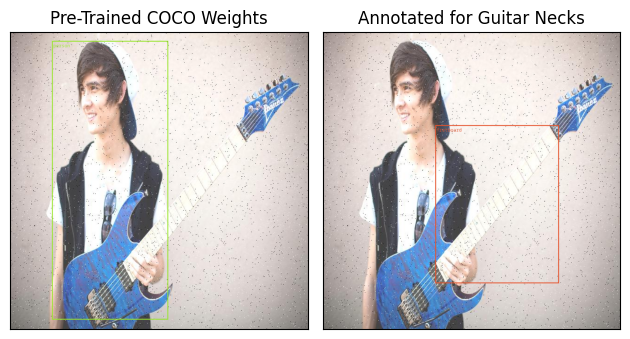

In [4]:
# Inference test before fine-tuning
model.eval()

image, target = train_dataset[45]

boxes, classes, labels = predict(image, model, available_device(), 0.6, 0.2, names=COCO_NAMES)

# Draw bounding boxes.
drawn_boxes = draw_colored_boxes(
    image, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES, show=False
)
drawn_boxes2 = draw_colored_boxes(
    image,
    target["boxes"],
    classes=target["labels"].tolist(),
    class_names=CUSTOM_COCO_NAMES,
    show=False,
)
show([drawn_boxes, drawn_boxes2], titles=["Pre-Trained COCO Weights", "Annotated for Guitar Necks"])

In [5]:
clean_cache()

model.train()

# Initialize wandb
run_name = config["model"]["name"] + "-" + wandb.util.generate_id()
wandb.init(
    project=wandb_config["project"],
    name=run_name,
    entity=wandb_config["entity"],
    config=config,
)

# Define training arguments
training_args = TrainingArguments(
    output_dir=config["training"]["output_dir"],
    num_train_epochs=config["training"]["num_epochs"],
    per_device_train_batch_size=config["training"]["batch_size"],
    per_device_eval_batch_size=config["training"]["batch_size"],
    logging_dir=config["training"]["logging_dir"],
    logging_steps=config["training"]["logging_steps"],
    warmup_steps=config["training"]["warmup_steps"] if "warmup_steps" in config["training"] else 0,
    weight_decay=config["training"]["weight_decay"] if "weight_decay" in config["training"] else 0,
    eval_strategy=config["training"]["eval_strategy"],
    save_strategy=config["training"]["eval_strategy"],
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="mAP50",
    learning_rate=float(config["training"]["learning_rate"]),
    greater_is_better=True,
    logging_strategy=config["training"]["eval_strategy"],
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=config["training"].get("early_stopping_patience", 3)
)

my_wandb_callback = CustomWandbCallback()

# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[early_stopping_callback, my_wandb_callback],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

# Start training
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Freeing GPU Memory
Free: 7390 MB	Total: 7843 MB


wandb: Currently logged in as: cama00005 (hwga-cj). Use `wandb login --relogin` to force relogin


  5%|▌         | 116/2320 [01:25<20:33,  1.79it/s]

{'loss': 0.4316, 'grad_norm': 0.5912937521934509, 'learning_rate': 2.32e-05, 'epoch': 1.0, 'train_loss': 50.068153381347656, 'train_cls_loss': 29.621543884277344, 'train_box_loss': 14.677973747253418, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
  5%|▌         | 116/2320 [01:34<20:33,  1.79it/s]

{'eval_loss': 4.1465983390808105, 'eval_mAP50': 0.0, 'eval_mAP50-95': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 9.2697, 'eval_samples_per_second': 9.493, 'eval_steps_per_second': 1.187, 'epoch': 1.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 2.0975875854492188, 'eval_box_loss': 1.4710134267807007}


 10%|█         | 232/2320 [03:00<25:31,  1.36it/s]  

{'loss': 0.2792, 'grad_norm': 5.278688907623291, 'learning_rate': 4.64e-05, 'epoch': 2.0, 'train_loss': 32.388710021972656, 'train_cls_loss': 12.116385459899902, 'train_box_loss': 17.68943214416504, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 10%|█         | 232/2320 [03:09<25:31,  1.36it/s]

{'eval_loss': 2.521868944168091, 'eval_mAP50': 0.8767111897468567, 'eval_mAP50-95': 0.4193129241466522, 'eval_precision': 0.20075632326256804, 'eval_recall': 0.24285496812092555, 'eval_runtime': 9.2581, 'eval_samples_per_second': 9.505, 'eval_steps_per_second': 1.188, 'epoch': 2.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.4279283285140991, 'eval_box_loss': 1.2665879726409912}


 15%|█▌        | 348/2320 [04:36<17:54,  1.84it/s]  

{'loss': 0.133, 'grad_norm': 3.497238874435425, 'learning_rate': 6.96e-05, 'epoch': 3.0, 'train_loss': 15.431822776794434, 'train_cls_loss': 3.6092400550842285, 'train_box_loss': 10.072386741638184, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 15%|█▌        | 348/2320 [04:45<17:54,  1.84it/s]

{'eval_loss': 1.7556991577148438, 'eval_mAP50': 0.9301416277885437, 'eval_mAP50-95': 0.6094868779182434, 'eval_precision': 0.28853784372519625, 'eval_recall': 0.3078255963894262, 'eval_runtime': 9.2921, 'eval_samples_per_second': 9.47, 'eval_steps_per_second': 1.184, 'epoch': 3.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.28329119086265564, 'eval_box_loss': 0.6717538833618164}


 20%|██        | 464/2320 [06:11<22:44,  1.36it/s]  

{'loss': 0.092, 'grad_norm': 3.240046501159668, 'learning_rate': 9.28e-05, 'epoch': 4.0, 'train_loss': 10.675198554992676, 'train_cls_loss': 2.6862542629241943, 'train_box_loss': 6.613593101501465, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 20%|██        | 464/2320 [06:20<22:44,  1.36it/s]

{'eval_loss': 2.0006847381591797, 'eval_mAP50': 0.9024789929389954, 'eval_mAP50-95': 0.528794527053833, 'eval_precision': 0.25941908849905587, 'eval_recall': 0.2829760369653987, 'eval_runtime': 9.3262, 'eval_samples_per_second': 9.436, 'eval_steps_per_second': 1.179, 'epoch': 4.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.29852530360221863, 'eval_box_loss': 0.6670792102813721}


 25%|██▌       | 580/2320 [07:47<21:15,  1.36it/s]  

{'loss': 0.082, 'grad_norm': 4.297131061553955, 'learning_rate': 9.560439560439561e-05, 'epoch': 5.0, 'train_loss': 9.506442070007324, 'train_cls_loss': 2.469189167022705, 'train_box_loss': 5.4174723625183105, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 25%|██▌       | 580/2320 [07:56<21:15,  1.36it/s]

{'eval_loss': 1.3715604543685913, 'eval_mAP50': 0.9551355242729187, 'eval_mAP50-95': 0.7122638821601868, 'eval_precision': 0.34775016812846665, 'eval_recall': 0.37226341428469084, 'eval_runtime': 9.249, 'eval_samples_per_second': 9.515, 'eval_steps_per_second': 1.189, 'epoch': 5.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.2078772783279419, 'eval_box_loss': 0.45603176951408386}


 30%|███       | 696/2320 [09:23<19:50,  1.36it/s]  

{'loss': 0.0629, 'grad_norm': 7.679964065551758, 'learning_rate': 8.923076923076924e-05, 'epoch': 6.0, 'train_loss': 7.302090167999268, 'train_cls_loss': 1.8719145059585571, 'train_box_loss': 4.0471577644348145, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 30%|███       | 696/2320 [09:32<19:50,  1.36it/s]

{'eval_loss': 1.7635245323181152, 'eval_mAP50': 0.9387568235397339, 'eval_mAP50-95': 0.7078190445899963, 'eval_precision': 0.3478791264008399, 'eval_recall': 0.3614639300809513, 'eval_runtime': 9.2617, 'eval_samples_per_second': 9.501, 'eval_steps_per_second': 1.188, 'epoch': 6.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.2685546875, 'eval_box_loss': 0.41451936960220337}


 35%|███▌      | 812/2320 [10:58<18:38,  1.35it/s]  

{'loss': 0.0489, 'grad_norm': 6.0373663902282715, 'learning_rate': 8.285714285714287e-05, 'epoch': 7.0, 'train_loss': 5.672368049621582, 'train_cls_loss': 1.5507506132125854, 'train_box_loss': 3.2322206497192383, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 35%|███▌      | 812/2320 [11:08<18:38,  1.35it/s]

{'eval_loss': 1.353692889213562, 'eval_mAP50': 0.9402651786804199, 'eval_mAP50-95': 0.7570227980613708, 'eval_precision': 0.36967721367697615, 'eval_recall': 0.38690271509420454, 'eval_runtime': 9.3282, 'eval_samples_per_second': 9.434, 'eval_steps_per_second': 1.179, 'epoch': 7.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.18096378445625305, 'eval_box_loss': 0.3642593324184418}


 40%|████      | 928/2320 [12:33<16:53,  1.37it/s]  

{'loss': 0.0424, 'grad_norm': 3.6340596675872803, 'learning_rate': 7.648351648351648e-05, 'epoch': 8.0, 'train_loss': 4.9130401611328125, 'train_cls_loss': 1.270463228225708, 'train_box_loss': 2.8210837841033936, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 40%|████      | 928/2320 [12:43<16:53,  1.37it/s]

{'eval_loss': 1.6160346269607544, 'eval_mAP50': 0.9398261308670044, 'eval_mAP50-95': 0.7713850736618042, 'eval_precision': 0.3749959523441882, 'eval_recall': 0.3893187191059531, 'eval_runtime': 9.3678, 'eval_samples_per_second': 9.394, 'eval_steps_per_second': 1.174, 'epoch': 8.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.21593698859214783, 'eval_box_loss': 0.33973371982574463}


 45%|████▌     | 1044/2320 [14:09<11:40,  1.82it/s] 

{'loss': 0.0349, 'grad_norm': 3.8771772384643555, 'learning_rate': 7.010989010989011e-05, 'epoch': 9.0, 'train_loss': 4.046605587005615, 'train_cls_loss': 1.0671294927597046, 'train_box_loss': 2.4122931957244873, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                   
 45%|████▌     | 1044/2320 [14:18<11:40,  1.82it/s]

{'eval_loss': 1.5378925800323486, 'eval_mAP50': 0.9404840469360352, 'eval_mAP50-95': 0.7873859405517578, 'eval_precision': 0.3871688491440541, 'eval_recall': 0.40036266924564795, 'eval_runtime': 9.286, 'eval_samples_per_second': 9.477, 'eval_steps_per_second': 1.185, 'epoch': 9.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.17811980843544006, 'eval_box_loss': 0.2948921024799347}


 50%|█████     | 1160/2320 [15:44<14:07,  1.37it/s]  

{'loss': 0.031, 'grad_norm': 4.4038405418396, 'learning_rate': 6.373626373626373e-05, 'epoch': 10.0, 'train_loss': 3.594435453414917, 'train_cls_loss': 0.9426828026771545, 'train_box_loss': 2.0588653087615967, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                   
 50%|█████     | 1160/2320 [15:54<14:07,  1.37it/s]

{'eval_loss': 1.4393479824066162, 'eval_mAP50': 0.9402651786804199, 'eval_mAP50-95': 0.7866204977035522, 'eval_precision': 0.3838539875148199, 'eval_recall': 0.39765921627623757, 'eval_runtime': 9.2895, 'eval_samples_per_second': 9.473, 'eval_steps_per_second': 1.184, 'epoch': 10.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.17548434436321259, 'eval_box_loss': 0.28900623321533203}


 50%|█████     | 1160/2320 [15:54<15:54,  1.22it/s]

{'train_runtime': 954.5314, 'train_samples_per_second': 19.297, 'train_steps_per_second': 2.431, 'train_loss': 0.1237921260554215, 'epoch': 10.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


TrainOutput(global_step=1160, training_loss=0.1237921260554215, metrics={'train_runtime': 954.5314, 'train_samples_per_second': 19.297, 'train_steps_per_second': 2.431, 'total_flos': 0.0, 'train_loss': 0.1237921260554215, 'epoch': 10.0})

In [6]:
# Clean the GPU memory cache
clean_cache()

# Log table data at the end of training
log_table_data(trainer, per_device_eval_batch_size=8)

# Save the final model
safe_save(trainer, os.path.join(Config.FINAL_MODELS_DIR, config["model"]["name"]))

# Evaluate on test set if available
if test_dataset:
    test_results = trainer.evaluate(test_dataset)
    print(f"Test results: {test_results}")
    wandb.log({"test": test_results})

# Log performance metrics
wandb.log(trainer.model_performance_analysis())

# Finish wandb run
wandb.finish()

Freeing GPU Memory
Free: 6768 MB	Total: 7843 MB


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Results: {'test_loss': 0.1288391649723053, 'test_mAP50': 0.9551355242729187, 'test_mAP50-95': 0.7122638821601868, 'test_precision': 0.34775016812846665, 'test_recall': 0.37226341428469084, 'test_runtime': 9.3853, 'test_samples_per_second': 9.376, 'test_steps_per_second': 1.172}


/home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/final_models/faster_rcnn already exists. Renaming existing file to: faster_rcnn_20240728_21_04_56


New model saved as: /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/final_models/faster_rcnn


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Test results: {'eval_loss': 0.06237819418311119, 'eval_mAP50': 1.0, 'eval_mAP50-95': 0.8096376061439514, 'eval_precision': 0.6799564187187949, 'eval_recall': 0.7071428571428572, 'eval_runtime': 1.5808, 'eval_samples_per_second': 9.489, 'eval_steps_per_second': 1.265, 'epoch': 10.0}
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Model Performance:
Parameters: 33242582
GFLOPs: 134.38
Inference Speed: 45.31 ms


wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 10 is less than current step: 11. Dropping entry: {'train/loss': 0.1237921260554215, 'train/cls_loss': 0.0, 'train/box_loss': 0.0, 'val/loss': 1.5421462059020996, 'val/cls_loss': 0.2491266131401062, 'val/box_loss': 0.5288373231887817, 'metrics/precision(B)': 0.6799564187187949, 'metrics/recall(B)': 0.7071428571428572, 'metrics/mAP50(B)': 1.0, 'metrics/mAP50-95(B)': 0.8096376061439514, '_timestamp': 1722193498.4757833}).


metrics/mAP50(B),▁▇████████
metrics/mAP50-95(B),▁▅▆▆▇▇████
metrics/precision(B),▁▅▆▆▇▇████
metrics/recall(B),▁▅▆▆█▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇█▅▃▃▂▂▁▁▁
train/cls_loss,█▄▂▁▁▁▁▁▁▁
train/loss,█▅▃▂▂▂▁▁▁▁
val/box_loss,█▇▃▃▂▂▁▁▁▁


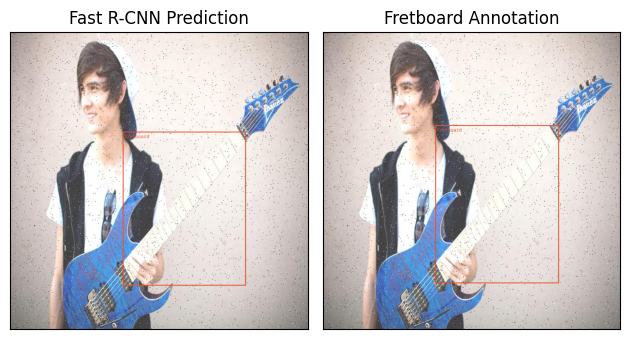

Predicted classes: ['fretboard']


In [7]:
model.eval()

image, target = train_dataset[45]

boxes, classes, labels = predict(
    image, model, available_device(), 0.2, 0.2, names=CUSTOM_COCO_NAMES
)

# Draw bounding boxes.
drawn_boxes = draw_colored_boxes(
    image, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES, show=False
)
drawn_boxes2 = draw_colored_boxes(
    image,
    target["boxes"],
    classes=target["labels"].tolist(),
    class_names=CUSTOM_COCO_NAMES,
    show=False,
)
show([drawn_boxes, drawn_boxes2], titles=["Fast R-CNN Prediction", "Fretboard Annotation"])
print(f"Predicted classes: {np.unique(classes)}")

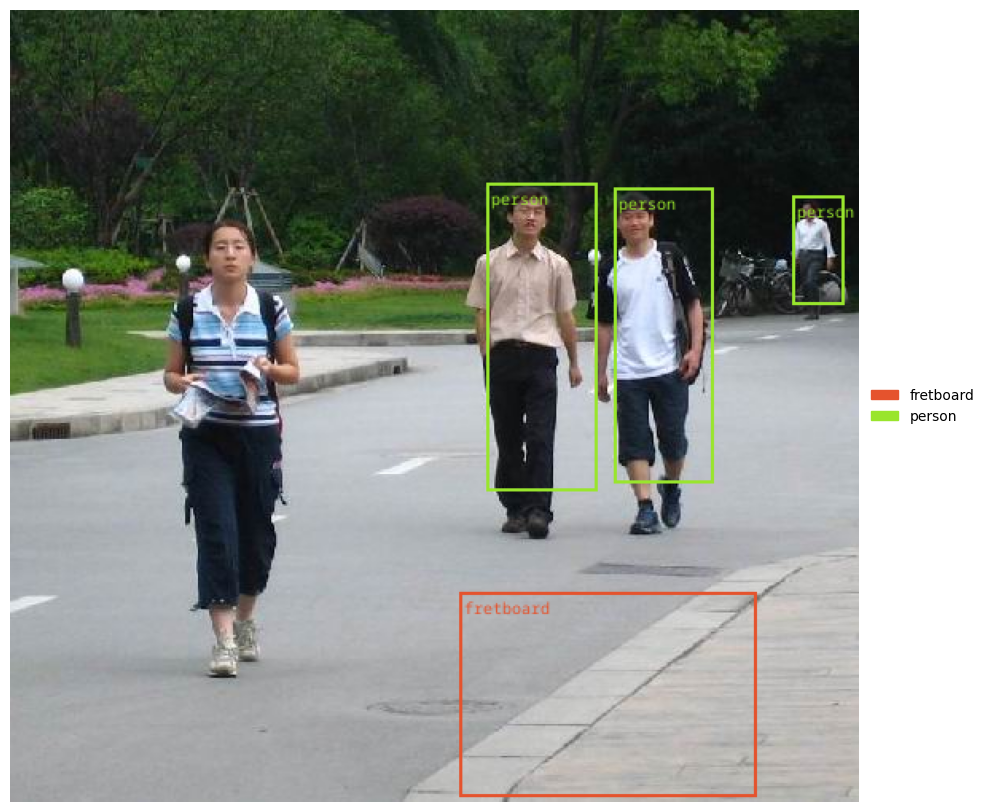

Predicted classes: ['fretboard' 'person']


In [8]:
model.eval()

img_path = os.path.join(Config.IMAGES_DIR, "FudanPed00054.png")
orig_img = read_image(img_path)

boxes, classes, labels = predict(
    orig_img,
    model,
    available_device(),
    0.1,
    0.1,
    model_transforms=model.get_transforms(),
    names=CUSTOM_COCO_NAMES,
)

drawn_boxes = draw_colored_boxes(orig_img, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES)
print(f"Predicted classes: {np.unique(classes)}")

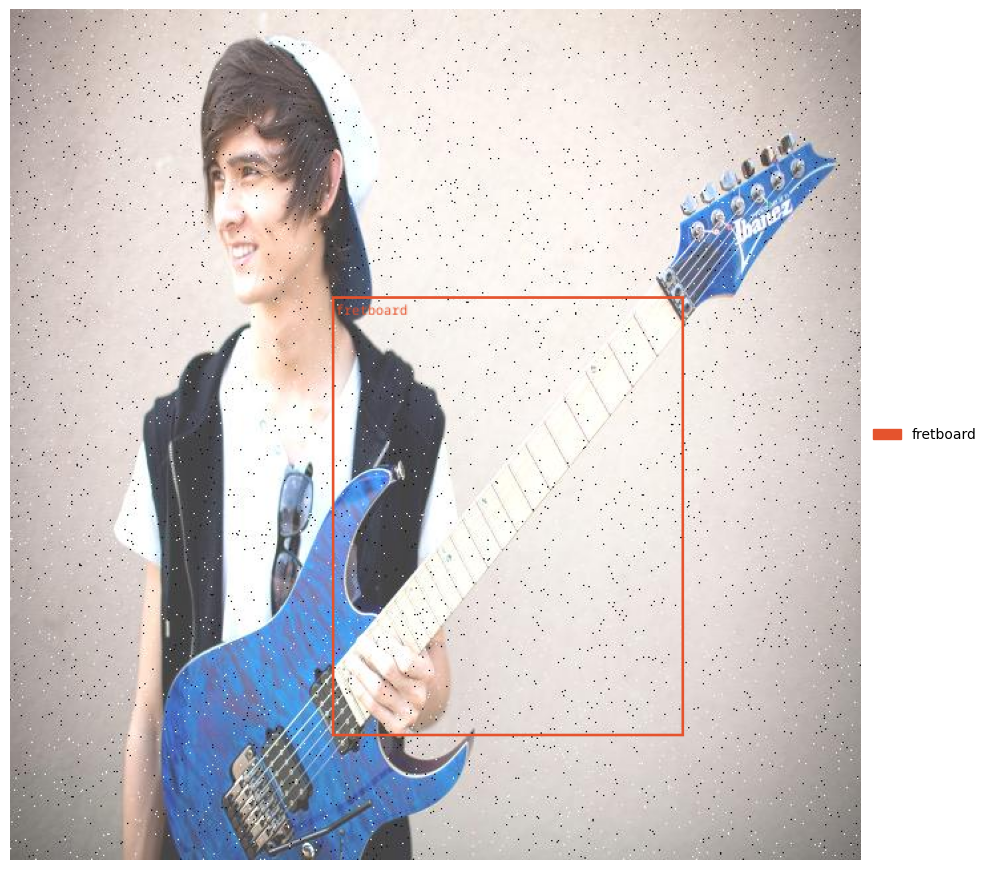

Predicted classes: ['fretboard']


In [9]:
model.eval()

image, target = train_dataset[45]

boxes, classes, labels = predict(
    image, model, available_device(), 0.2, 0.2, names=CUSTOM_COCO_NAMES
)

# Draw bounding boxes.
drawn_boxes = draw_colored_boxes(image, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES)
print(f"Predicted classes: {np.unique(classes)}")